In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym

<br>

# PID controllers
---



<br>

### The problem

We have system to control: we want to move an object of 1kg along a vertical line, in order to reach the altitude $h$. Once the object is at altitude $h$, we want for the object to stay there until an order for a new altitude comes in.

* the **goal** is the target we want to achieve (ex: a given position, a temperature of 20°C, etc.)
* the **error** is the difference between us and the goal (ex: 5 meters too low, 4°C to high, etc.)

To control the system, we have a motor to which we can give a **signal**, a numerical value that controls the among of power the motor generates. In our case, the characteristic of the motor is such that the signal $s$ induces a force of $p \times s$ Newtons applied upward on the object, while the gravity is equal to $m \times g$ Newtons and pointing downward.

<br>

### The Proportial part

The naive answer to the problem is to apply a signal **proportional to the error** plus some constant. If the error is zero, the signal should compensate for the gravity. If the error is negative, that is if the altitude is too high, decrease the strength of the signal, otherwise increase it if the error is positive.

&emsp; $s = k_p \, e + c$
&emsp; where
&emsp; $e = h - x$
&emsp; $h$ is our target altitude
&emsp; $x$ is our altitude

Computing the constant is rather easy, as we simply need the two forces to compensate for each other:

&emsp; $\displaystyle F = p \, c - m \, g = 0 \implies c = \frac{m \, g}{p}$

We can then try different **constant of proportionality** $k_p$, showing the different curves of altitude with respect to time. In the general case, even the constant will need to be found by hand if the system is complex:

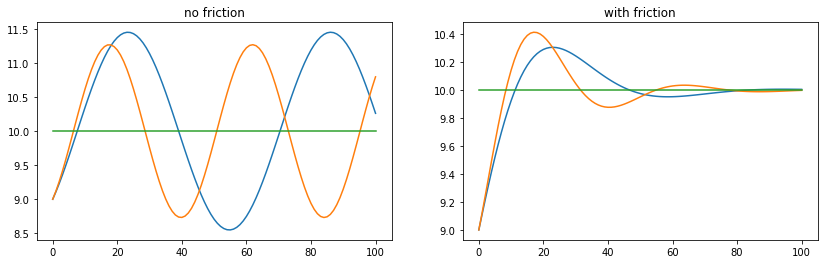

In [64]:
POWER=10
MASS=1
GRAV=9.8
DT = 0.1
DURATION=10.

def simulate(controler, x_0: float, x_t: float, v_0: float, friction=0.1, dt=DT, duration=DURATION):
    xs = [x_0]
    vs = [v_0]
    for _ in range(int(duration / dt)):
        v = vs[-1] + dt * (POWER / MASS * controler(x_t, xs[-1], vs[-1]) - GRAV)
        vs.append(v * (1 - friction))
        xs.append(xs[-1] + dt * v)
    return xs

def constant(x_t: float, dt=DT, duration=DURATION):
    return [x_t for _ in range(1 + int(duration / dt))]

class ProportionalControler:
    def __init__(self, k_p: float):
        self.k_p = k_p
        self.c = MASS / POWER * GRAV
    
    def __call__(self, x_t: float, x: float, v: float):
        return self.k_p * (x_t - x) + self.c
    
_, ax = plt.subplots(figsize=(14,4), ncols=2)
ax[0].plot(simulate(ProportionalControler(0.1), x_0=9., x_t=10., v_0=1., friction=0.))
ax[0].plot(simulate(ProportionalControler(0.2), x_0=9., x_t=10., v_0=1., friction=0.))
ax[0].plot(constant(10.))
ax[0].set_title("no friction")
ax[1].plot(simulate(ProportionalControler(0.1), x_0=9., x_t=10., v_0=1.))
ax[1].plot(simulate(ProportionalControler(0.2), x_0=9., x_t=10., v_0=1.))
ax[1].plot(constant(10.))
ax[1].set_title("with friction")
plt.show()

<br>

### The Derivative Part

To see why our previous attempt failed, we can write down the equation of the movement of the system without frictions, and replace the signal $s$ with its value $s = k_p (h - x) + \frac{m g}{p}$ and assume that the target altitude is 0:

&emsp; $\displaystyle m \ddot{x} = p s - m g = k_p (h - x) = -k x \implies x = \cos \sqrt{k} t + x_0$

And so we have an oscillation. The reason is simple: we keep on accelerating although we might already have enough acceleration when we are below the target point, then we do the same when above. By symmetry, we must have a sinusoid.

As we can see from above, this oscillation is controlled if we add some friction, which is equivalent to adding some term in our signal that is linear in the speed. Our signal now gains another constant that is **proportional to the derivative of the error**.

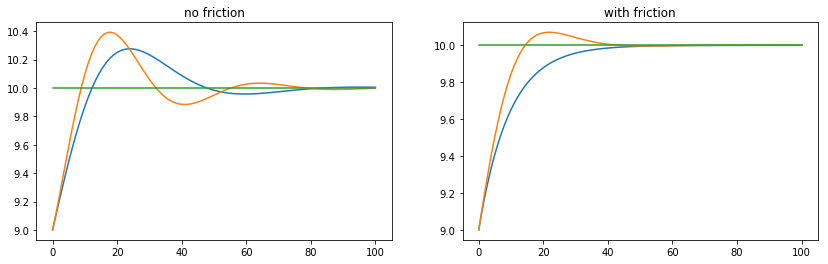

In [66]:
class PDControler:
    def __init__(self, k_p: float, k_d: float):
        self.k_p = k_p
        self.k_d = k_d
        self.c = MASS / POWER * GRAV
    
    def __call__(self, x_t: float, x: float, v: float):
        return self.k_p * (x_t - x) - self.k_d * v + self.c
    
_, ax = plt.subplots(figsize=(14,4), ncols=2)
ax[0].plot(simulate(PDControler(k_p=0.1, k_d=0.1), x_0=9., x_t=10., v_0=1., friction=0.))
ax[0].plot(simulate(PDControler(k_p=0.2, k_d=0.1), x_0=9., x_t=10., v_0=1., friction=0.))
ax[0].plot(constant(10.))
ax[0].set_title("no friction")
ax[1].plot(simulate(PDControler(k_p=0.1, k_d=0.1), x_0=9., x_t=10., v_0=1.))
ax[1].plot(simulate(PDControler(k_p=0.2, k_d=0.1), x_0=9., x_t=10., v_0=1.))
ax[1].plot(constant(10.))
ax[1].set_title("with friction")
plt.show()

<br>

### The Integrated Part

Because of the dampening effect of the derivative part, the error will never manage to reach 0. We can see it in the graph above: the curve goes asymptotically to the goal, but never quite reaches it. To make the convergence faster, the idea is to add a component that is **proportional to the integral** of the error:

* If the error is positive (we are below the curve), it strengthens the signal
* If the error is negative (goes above the curve), it decreases the signal

This error is even more important in other kind of control systems, such as the ones where the output of the circuit is directly proportional to the error $e$ (typical in electronics), and the goal $g$ cannot never be reached:

&emsp; $\displaystyle x = k_p \, e \implies x = k_p (g - x) \implies x = \frac{k_p}{1 + k_p} g$
&emsp; (the fixed point is never the goal)

This integrated error also allows to reach convergence faster, boosting the strength of the signal initially. The complete signal is therefore of the following form (with $\Delta t$ limiting the integral to a fixed portion of our past):

&emsp; $\displaystyle \boxed{s(t) = k_p \, e(t) + k_d \, \frac{de}{dt} (t) + k_i \int_{t-\Delta t}^t e(t) \, dt + k_c}$

We call **PID Controller** (Proportional Integrated Derivative) a controler whose formula is based on those three components. The constants $k_p$, $k_d$, $k_i$ and $k_c$ depend on the problem and the constants at hand and need to be found empirically.

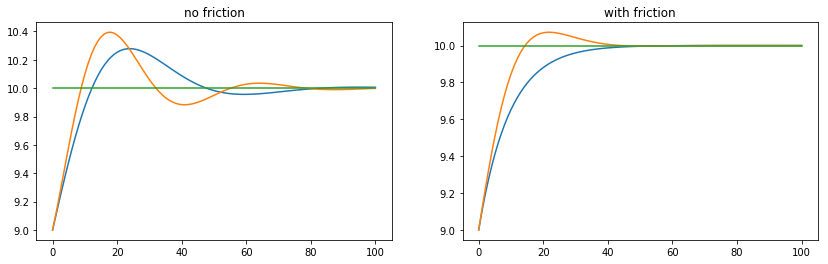

In [69]:
class PIDControler:
    def __init__(self, k_p: float, k_d: float, k_i: float, dt=DT):
        self.k_p = k_p
        self.k_d = k_d
        self.k_i = k_i
        self.dt = DT
        self.total_error = 0.
        self.c = MASS / POWER * GRAV
    
    def __call__(self, x_t: float, x: float, v: float):
        e = x_t - x
        self.total_error = self.total_error * 0.9 + 0.1 * e * self.dt # Moving average instead of integral
        return self.k_p * (x_t - x) - self.k_d * v + self.k_i * self.total_error + self.c
    
_, ax = plt.subplots(figsize=(14,4), ncols=2)
ax[0].plot(simulate(PIDControler(k_p=0.1, k_d=0.1, k_i=0.01), x_0=9., x_t=10., v_0=1., friction=0.))
ax[0].plot(simulate(PIDControler(k_p=0.2, k_d=0.1, k_i=0.01), x_0=9., x_t=10., v_0=1., friction=0.))
ax[0].plot(constant(10.))
ax[0].set_title("no friction")
ax[1].plot(simulate(PIDControler(k_p=0.1, k_d=0.1, k_i=0.01), x_0=9., x_t=10., v_0=1.))
ax[1].plot(simulate(PIDControler(k_p=0.2, k_d=0.1, k_i=0.01), x_0=9., x_t=10., v_0=1.))
ax[1].plot(constant(10.))
ax[1].set_title("with friction")
plt.show()

<br>

### Limitations

All the reasonning above is based on the fact that the power generated by the motor (or in general the effect we product) is proportional to the signal we send to it ($p \times s$ Newtons above). While most motors do not have a linear response to their inputs, they usually do have a linear regime, and **PID controlers** are meant to operate in this **linear regime**.

To deal with non-linear regimes, we could ideally transform the signal in order to fall back to a linear system. If we know that the output of the motor is $f(s)$, we can transform our signal $\phi : s \mapsto f^{-1}(p s)$, so that the output of the motor is $p \times s$.

But in general, this will not be possible:

* $f$ would need to be invertible
* $p \times s$ would need to be in the domain of $f^{-1}$ or equivalently in the co-domain of $f$

This is for instance impossible for a typical regime of motor that looks like a $\tanh$ curve whose codomain is $]-1, 1[$:

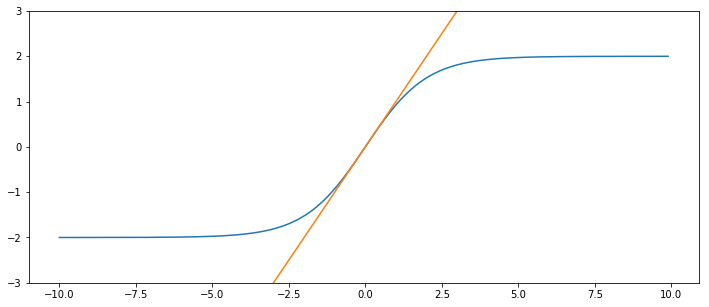

In [80]:
s = np.arange(-10, 10, 0.1)
p = 2 * np.tanh(s / 2)      # Power in function of signal
plt.figure(figsize=(12, 5))
plt.plot(s, p)
plt.plot(s, s)
plt.ylim(-3, 3)
plt.show()